In [51]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
import itertools

import warnings
warnings.filterwarnings('ignore')

# SET THE IMAGE SIZE
IMAGE_SIZE = 28

def get_data(train_test):

  target_directories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  
  cwd = os.getcwd()
  data = []

  for dir in target_directories:
      path = os.path.realpath(f'Data/{train_test}/{dir}/')
      for filename in os.listdir(path):

          #Read in Image
          filepath = f"{path}\\{filename}"
          img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

          #Resize Image
          desired_size = IMAGE_SIZE
          old_size = img.shape[:2] # old_size is in (height, width) format

          ratio = float(desired_size)/max(old_size)
          new_size = tuple([int(x*ratio) for x in old_size])

          img = cv2.resize(img, (new_size[1], new_size[0]))

          delta_w = desired_size - new_size[1]
          delta_h = desired_size - new_size[0]
          top, bottom = delta_h//2, delta_h-(delta_h//2)
          left, right = delta_w//2, delta_w-(delta_w//2)

          color = [255, 255, 255]
          img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

          data.append([img, dir])

  return data


train_data = get_data("train")
test_data = get_data("test")

X_train = []
Y_train = []
X_test = []
Y_test = []

for feature, label in train_data:
  X_train.append(feature)
  Y_train.append(label)

for feature, label in test_data:
  X_test.append(feature)
  Y_test.append(label)

# Normalize the data
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes= 10)

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.05)

model = Sequential()

model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)         

In [52]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 64 
batch_size = 12

datagen = ImageDataGenerator(
        rotation_range=12,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

datagen.fit(X_train)

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              validation_data = (X_val, Y_val),
                              epochs = epochs, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/64
83/83 [==============================] - 1s 11ms/step - loss: 2.3213 - accuracy: 0.0991 - val_loss: 2.3061 - val_accuracy: 0.0566
Epoch 2/64
83/83 [==============================] - 1s 9ms/step - loss: 2.3034 - accuracy: 0.1215 - val_loss: 2.3087 - val_accuracy: 0.0377
Epoch 3/64
83/83 [==============================] - 1s 9ms/step - loss: 2.3036 - accuracy: 0.1144 - val_loss: 2.3108 - val_accuracy: 0.0377
Epoch 4/64
83/83 [==============================] - 1s 9ms/step - loss: 2.3040 - accuracy: 0.0998 - val_loss: 2.2860 - val_accuracy: 0.0943
Epoch 5/64
83/83 [==============================] - 1s 9ms/step - loss: 2.1442 - accuracy: 0.2884 - val_loss: 1.5891 - val_accuracy: 0.4340
Epoch 6/64
83/83 [==============================] - 1s 9ms/step - loss: 1.6615 - accuracy: 0.4388 - val_loss: 1.4571 - val_accuracy: 0.4717
Epoch 7/64
83/83 [==============================] - 1s 9ms/step - loss: 1.5032 - accuracy: 0.5218 - val_loss: 1.2177 - val_accuracy: 0.5849
Epoch 8/64
83/83 [=

83/83 [==============================] - 1s 9ms/step - loss: 0.0779 - accuracy: 0.9753 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 57/64
83/83 [==============================] - 1s 9ms/step - loss: 0.1115 - accuracy: 0.9707 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 58/64
83/83 [==============================] - 1s 9ms/step - loss: 0.0910 - accuracy: 0.9732 - val_loss: 0.0068 - val_accuracy: 1.0000

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 59/64
83/83 [==============================] - 1s 9ms/step - loss: 0.1430 - accuracy: 0.9525 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 60/64
83/83 [==============================] - 1s 9ms/step - loss: 0.0894 - accuracy: 0.9730 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 61/64
83/83 [==============================] - 1s 9ms/step - loss: 0.1042 - accuracy: 0.9699 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 62/64
83/83 [==============================] - 1s 9ms/step - loss: 0.1378 - ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


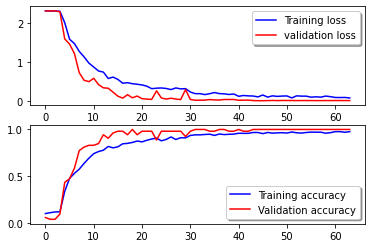

In [53]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

print(history.history.keys())

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

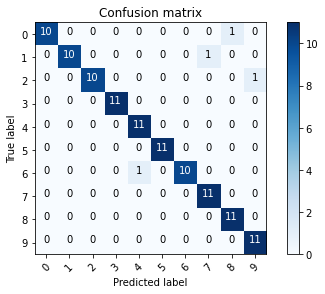

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [55]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       1.00      0.91      0.95        11
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        11
           4       0.92      1.00      0.96        11
           5       1.00      1.00      1.00        11
           6       1.00      0.91      0.95        11
           7       0.92      1.00      0.96        11
           8       0.92      1.00      0.96        11
           9       0.92      1.00      0.96        11

    accuracy                           0.96       110
   macro avg       0.97      0.96      0.96       110
weighted avg       0.97      0.96      0.96       110



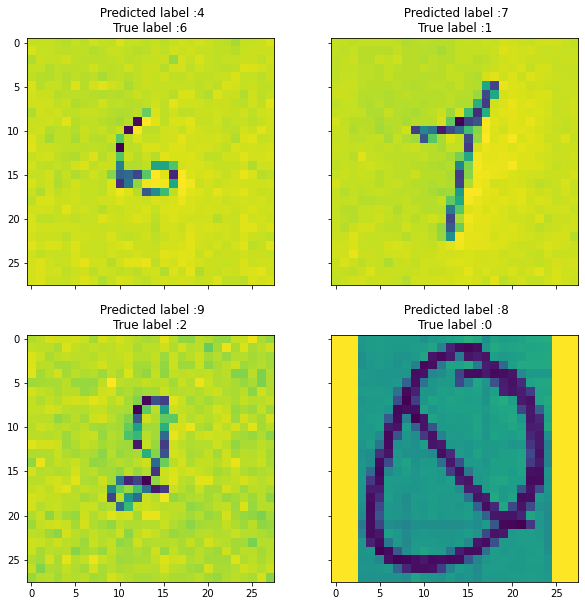

In [57]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 4 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title(f" Predicted label :{pred_errors[error]}\nTrue label :{obs_errors[error]}")
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 4 errors 
most_important_errors = sorted_dela_errors[-4:]

# Show the top 4 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)